In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os
import pandas as pd


In [3]:
# Compile galaxy and OSC objects
# full catalog header: Name,Type,Host,RA hms,Dec dms,RA dds,Dec dds,DiscDate
Data = pd.read_csv('../Data/2.MUSESampleCat.csv')
# Data.join(Gal, on=['Galaxy', 'Distance', 'Incl'])
Data.head()


,Galaxy,Distance,Incl,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity,coptMap,CO21,eCO21,InSample
0,NGC1087,15.85,42.9,SN1995V,II,41.611528,-0.498786,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2....,../Data/IRAC/ngc1087_irac1_atGauss4.fits,8.839673e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...,True
1,NGC1300,18.99,31.8,SN2022acko,II,49.912458,-19.395189,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2....,../Data/IRAC/ngc1300_irac1_atGauss4.fits,3.445745e+38,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_...,True
2,NGC1365,19.57,55.4,SN1957C,Unclassified,53.383500,-36.117708,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2....,../Data/IRAC/ngc1365_irac1_atGauss4.fits,2.938519e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True
3,NGC1365,19.57,55.4,SN1983V,Ic,53.381876,-36.148592,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2....,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.484566e+40,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True
4,NGC1365,19.57,55.4,SN2001du,II,53.371313,-36.142111,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2....,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.353044e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True


In [4]:
# maps150, maps1kpc = [],[]

maps150 = [x[:-5] + "_150pc.fits" for x in Data["coptMap"]]
maps1kpc = [x[:-5] + "_1kpc.fits" for x in Data["coptMap"]]

Data['Maps150'] = maps150
Data['Maps1kpc'] = maps1kpc

In [5]:
Data.head()

,Galaxy,Distance,Incl,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity,coptMap,CO21,eCO21,InSample,Maps150,Maps1kpc
0,NGC1087,15.85,42.9,SN1995V,II,41.611528,-0.498786,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2....,../Data/IRAC/ngc1087_irac1_atGauss4.fits,8.839673e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...
1,NGC1300,18.99,31.8,SN2022acko,II,49.912458,-19.395189,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2....,../Data/IRAC/ngc1300_irac1_atGauss4.fits,3.445745e+38,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...
2,NGC1365,19.57,55.4,SN1957C,Unclassified,53.383500,-36.117708,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2....,../Data/IRAC/ngc1365_irac1_atGauss4.fits,2.938519e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...
3,NGC1365,19.57,55.4,SN1983V,Ic,53.381876,-36.148592,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2....,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.484566e+40,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...
4,NGC1365,19.57,55.4,SN2001du,II,53.371313,-36.142111,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2....,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.353044e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...


In [6]:
IntensityFile = '../Data/2.Intensities.csv'
Ints = pd.read_csv(IntensityFile) 
Ints.head()

,Supernova,Type,Int_native,Int_150,Int_1kpc
0,SN2013ej,II,nan,nan,nan
1,SN2019krl,IIn/LBV,447.33069091690675,117.73639895611818,119.62957869932427
2,SN1995V,II,2663.371834437333,2851.2831264857423,2205.8805081294695
3,SN2022acko,II,215.43198181769688,291.42165400604426,368.4731780423753
4,SN1957C,Unclassified,1737.6042541521983,1863.6718999131263,2010.432522712961


In [7]:
Data["Int_nat"], Data["Int_150"], Data["Int_1kpc"] = np.full(len(Data),np.nan),np.full(len(Data),np.nan),np.full(len(Data),np.nan)

for i in range(len(Data['Supernova'])):
    for j in range(len(Ints["Supernova"])):
        if Data["Supernova"][i] == Ints["Supernova"][j].strip():
            Data["Int_nat"][i] = Ints["Int_native"][j]
            Data["Int_150"][i] = Ints["Int_150"][j]
            Data["Int_1kpc"][i] = Ints["Int_1kpc"][j]

Data.head()

,Galaxy,Distance,Incl,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,...,Intensity,coptMap,CO21,eCO21,InSample,Maps150,Maps1kpc,Int_nat,Int_150,Int_1kpc
0,NGC1087,15.85,42.9,SN1995V,II,41.611528,-0.498786,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,...,8.839673e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,2663.371834437333,2851.2831264857423,2205.8805081294695
1,NGC1300,18.99,31.8,SN2022acko,II,49.912458,-19.395189,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,...,3.445745e+38,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,215.43198181769688,291.42165400604426,368.4731780423753
2,NGC1365,19.57,55.4,SN1957C,Unclassified,53.383500,-36.117708,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,...,2.938519e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,1737.6042541521983,1863.6718999131263,2010.432522712961
3,NGC1365,19.57,55.4,SN1983V,Ic,53.381876,-36.148592,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,...,1.484566e+40,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,5743.357614386635,4415.65792299896,521.3173631684485
4,NGC1365,19.57,55.4,SN2001du,II,53.371313,-36.142111,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/N...,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc...,...,1.353044e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_...,True,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1...,929.5770449217084,1147.752336641269,2187.0730284798246


In [8]:
# isolate discovery year
year = []
for j in range(len(Data)):
    yearDigits = [int(i) for i in Data["Supernova"][j] if i.isdigit()]
    # fix for ASAS-SN14
    if len(yearDigits)<4:
        yearDigits.insert(0,0)
        yearDigits.insert(0,2)
    yearDigits = int(''.join(map(str,yearDigits)))
    year.append(yearDigits)
    
    #flag SNe since 2000
goodSample = np.where(np.asarray(year) > 1999, 1, 0)
goodSample


array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1])

In [10]:
SNtype = Data["Type"]

# homogonize type classifications
for i in range(len(SNtype)):
    if "II" == SNtype[i][:2]:
        SNtype[i] = "II"
    elif "Ia" == SNtype[i][:2]:
        SNtype[i] = "Ia"
    elif SNtype[i] == "I" or "U" == SNtype[i][:1]:
        SNtype[i] = "Unclassified"
    else:
        SNtype[i] = "Ib/c"

print(SNtype)
# Sort SN Type 
typeII_idx   = np.where(SNtype=="II")
typeIa_idx   = np.where(SNtype=="Ia")
typeIbc_idx  = np.where(SNtype=="Ib/c")
typeUnc_idx  = np.where(SNtype=="Unclassified")

numTypeII  = len(typeII_idx[0])
numTypeIa  = len(typeIa_idx[0])
numTypeIbc = len(typeIbc_idx[0])
numTypeUnc = len(typeUnc_idx[0])

print("Type II: ",numTypeII)
print("Type Ia: ",numTypeIa)
print("SESNe: ",numTypeIbc)
print("Unclassified: ",numTypeUnc)
print(len(SNtype))

0               II
1               II
2     Unclassified
3             Ib/c
4               II
5               Ia
6               II
7               II
8               Ia
9               Ia
10            Ib/c
11              II
12              II
13              Ia
14              II
15              II
16              II
17              II
18              II
19              II
20            Ib/c
21              II
22              II
23              II
24              II
25              II
26              Ia
27              II
28    Unclassified
29    Unclassified
30              Ia
31            Ib/c
32            Ib/c
Name: Type, dtype: object
Type II:  19
Type Ia:  6
SESNe:  5
Unclassified:  3
33


In [11]:
#get intensities
int_nat  = [float(i) for i in Data["Int_nat"]]
int_150  = [float(i) for i in Data["Int_150"]]
int_1kpc = [float(i) for i in Data["Int_1kpc"]]

# print(int_nat, int_150, int_1kpc)

In [12]:
# normalize intensities
int_nat = np.clip(int_nat,0,np.max(int_nat))
int_150 = np.clip(int_150,0,np.max(int_150))
int_1kpc = np.clip(int_1kpc,0,np.max(int_1kpc))


In [13]:
# get SN intensities by type
II_int  = int_nat[typeII_idx]
Ia_int  = int_nat[typeIa_idx]
Ibc_int = int_nat[typeIbc_idx]
Unc_int = int_nat[typeUnc_idx]

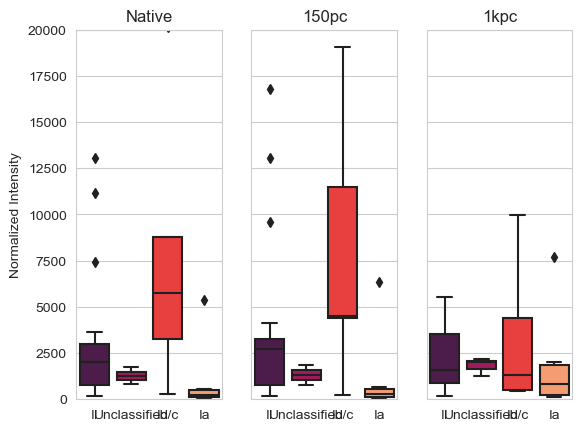

In [14]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=4, desat=None, color_codes=False)

fig,ax = plt.subplots(1,3)
# plot y in log and same y scale
sns.boxplot(y = int_nat, x = SNtype, ax=ax[0],saturation=1)
sns.boxplot(y = int_150, x = SNtype, ax=ax[1],saturation=1)
sns.boxplot(y = int_1kpc, x = SNtype, ax=ax[2],saturation=1)
ax[0].set(title = "Native",ylim=(0, 20000),ylabel="Normalized Intensity",xlabel=None)
ax[1].set(title = "150pc",ylim=(0, 20000),xlabel=None)
ax[1].set_yticklabels([])
ax[2].set(title = "1kpc",ylim=(0, 20000),xlabel=None)
ax[2].set_yticklabels([])

plt.show()
plt.close()
# fig.savefig("../Figures/IntensityViolin.pdf", dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


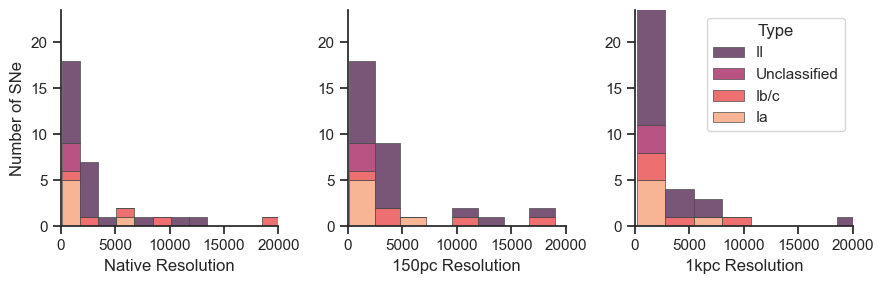

In [15]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(1,3)
f.set_figheight(3)
f.set_figwidth(9)
sns.despine(f)

sns.histplot(
    x=int_nat, hue=SNtype,
    multiple="stack",     
    bins=12,
    palette="rocket",
    edgecolor=".3",
    kde=False,
    linewidth=.5,
    log_scale=False, 
    legend=False,
    ax=ax[0])
ax[0].legend(frameon=False)
ax[0].set_ylabel("Number of SNe")
ax[0].set_xlabel('Native Resolution')
ax[0].set_xlim(0, 20000)
ax[0].set_ylim(0,23.5)

sns.histplot(
    x=int_150, hue=SNtype,
    multiple="stack",     
    bins=8,
    palette="rocket",
    edgecolor=".3",
    kde=False,
    linewidth=.5,
    log_scale=False,
    legend=False,
    ax=ax[1])
ax[1].set_xlim(0, 20000)
ax[1].set_ylim(0,23.5)

ax[1].set_ylabel("")
ax[1].set_xlabel('150pc Resolution')
sns.histplot(
    x=int_1kpc, hue=SNtype,
    multiple="stack",     
    bins=8,
    palette="rocket",
    edgecolor=".3",
    kde=False,
    linewidth=.5,
    log_scale=False,
    legend=True,
    ax=ax[2])
ax[2].set_xlim(0, 20000)
ax[2].set_ylim(0,23.5)

ax[2].set_ylabel("")
ax[2].set_xlabel('1kpc Resolution')

plt.tight_layout()
plt.savefig("../Figures/HIIIntHist.png", dpi=300)

In [16]:
int_nat_files  = Data['coptMap'].unique()
int_150_files  = Data['Maps150'].unique()
int_1kpc_files = Data['Maps1kpc'].unique()

In [17]:
# get pixel values for a galaxy map
def get_map_pixels(image, ext):
    
    #open fits and access map data
    hdulist  = pyfits.open(image)    
    map = hdulist[ext].data
    
    #flatten map and remove nans
    f_map = map.flatten()
    keep  = np.where(np.isfinite(f_map))
    pixels = f_map[keep]
    
    #return list of pixels
    return(pixels)

# compile pixels from all galaxy maps to a flattened list
def compile_maps(images, ext): 
    pixels = []
    
    #append pixels from each map
    for image in images:
        pixels.append(get_map_pixels(image, ext=ext))
        
    #flatten into a single list
    pixels = np.hstack(pixels)    
    
    return(pixels)
    
#make ncdf from list of pixels
def make_ncdf(pixel_list):
    pixel_list.sort()
    cdf = np.cumsum(pixel_list)
    ncdf = cdf/cdf[-1]
    return(ncdf)

#make ncdf from list of galaxies
def make_gal_ncdf(images, ext):
    pixels = compile_maps(images,ext=ext)
    ncdf = make_ncdf(pixels)
    return(ncdf)


In [18]:
# Make NCR plot for SN intensities at all res and all pixels at all res
ncdf_nat_pix = make_gal_ncdf(int_nat_files, ext=1)
ncdf_nat_SNe = make_ncdf(list(int_nat))
ncdf_150_pix = make_gal_ncdf(int_150_files, ext=0)
ncdf_150_SNe = make_ncdf(list(int_150))
ncdf_1kpc_pix = make_gal_ncdf(int_1kpc_files, ext=0)
ncdf_1kpc_SNe = make_ncdf(list(int_1kpc))


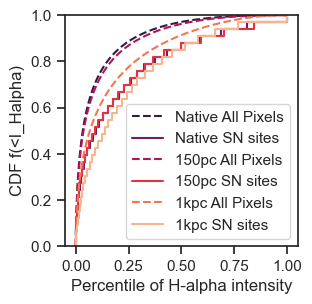

In [19]:
sns.set_palette("rocket", n_colors=6, desat=None, color_codes=False)

fig = plt.figure(figsize = (3,3))

plt.xlabel("Percentile of H-alpha intensity")
plt.ylabel("CDF f(<I_Halpha)")
sns.ecdfplot(ncdf_nat_pix, ls="--",label="Native All Pixels")
sns.ecdfplot(ncdf_nat_SNe, ls="-",label="Native SN sites")
sns.ecdfplot(ncdf_150_pix, ls="--",label="150pc All Pixels")
sns.ecdfplot(ncdf_150_SNe, ls="-",label="150pc SN sites")
sns.ecdfplot(ncdf_1kpc_pix, ls="--",label="1kpc All Pixels")
sns.ecdfplot(ncdf_1kpc_SNe, ls="-",label="1kpc SN sites")
plt.legend(loc="best")

In [20]:
# need to find value of ncdf_nat_pix for each value of ncdf_nat_SNe
print(len(ncdf_nat_SNe), len(ncdf_nat_pix))
print(ncdf_nat_pix)

33 8862018
[0.         0.         0.         ... 0.94150248 0.94164788 1.        ]


In [21]:
def find_nearest(arr, x):
    difference_array = np.absolute(arr-x)
    index = difference_array.argmin()
    return(index)

def find_percentile(arr, index):
    percentile = index/float(len(arr))
    return(percentile)

def make_ncr(sn_arr,pix_arr):
    sn_per_arr,pix_per_arr = [0],[0]  # initialize at zero to make plot begin from 0,0

    sn_arr.sort()    
    pix_ncdf = make_ncdf(pix_arr)
    
    for i in range(len(sn_arr)):
        index = find_nearest(pix_arr, sn_arr[i])
#         pix_per = find_percentile(pix_arr, index)
        pix_per = pix_ncdf[index]
        sn_per = find_percentile(sn_arr, i)
        sn_per_arr.append(sn_per + 1./len(sn_arr)) # add term to start appropiately and to end at 1.0
        pix_per_arr.append(pix_per)#  + 1./len(pix_arr))
    
    return(pix_per_arr, sn_per_arr)

    

In [22]:
pix_nat  = compile_maps(int_nat_files, ext=1)
pix_150  = compile_maps(int_150_files, ext=0)
pix_1kpc = compile_maps(int_1kpc_files, ext=0)

pix_per_arr_nat,  sn_per_arr_nat  = make_ncr(int_nat,pix_nat)
pix_per_arr_150,  sn_per_arr_150  = make_ncr(int_150,pix_150)
pix_per_arr_1kpc, sn_per_arr_1kpc = make_ncr(int_1kpc,pix_1kpc)


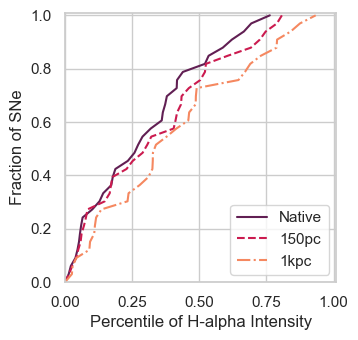

In [23]:
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=3, desat=None, color_codes=False)

fig = plt.figure(figsize = (3.5,3.5))

plt.xlabel("Percentile of H-alpha Intensity")
plt.ylabel("Fraction of SNe")
ax = sns.lineplot(pix_per_arr_nat,  sn_per_arr_nat, ls="-",label="Native")
ax = sns.lineplot(pix_per_arr_150,  sn_per_arr_150, ls="-",label="150pc")
ax = sns.lineplot(pix_per_arr_1kpc, sn_per_arr_1kpc, ls="-",label="1kpc")
ax.lines[0].set_linestyle("-")
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("-.")

plt.xlim(0,1.01)
plt.ylim(0,1.01)
plt.legend(loc="lower right")
plt.savefig("../Figures/resolutionNCR.png", dpi=300)

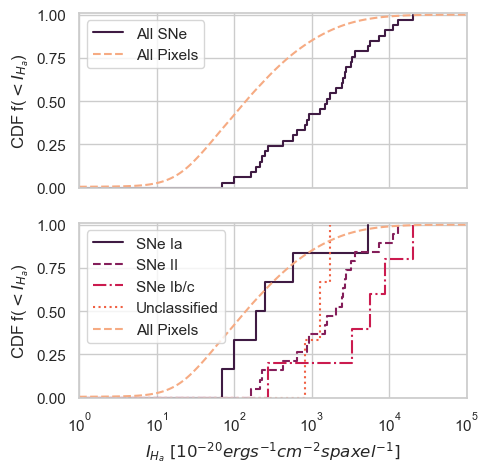

In [39]:
# plot the CDFs
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=5, desat=None, color_codes=False)

fig,ax= plt.subplots(2, 1)   
fig.set_figheight(5)
fig.set_figwidth(5)
sns.ecdfplot(int_nat, label = "All SNe", ax=ax[0])
sns.ecdfplot(pix_nat, label = "All Pixels", color='#f6ab83', ax=ax[0])
ax[0].lines[1].set_linestyle("--")


ax[0].legend(loc='best')
ax[0].set(xscale="log",ylabel =r'CDF f($<I_{H_a}$)',
       xlim=(1,1e5),ylim=(0,1.01),xticklabels=[])

sns.ecdfplot(Ia_int, label = "SNe Ia", ax=ax[1])
sns.ecdfplot(II_int, label = "SNe II", ax=ax[1])
sns.ecdfplot(Ibc_int, label = "SNe Ib/c", ax=ax[1])
sns.ecdfplot(Unc_int, label = "Unclassified", ax=ax[1])
sns.ecdfplot(pix_nat, label = "All Pixels", ax=ax[1])
ax[1].lines[1].set_linestyle("--")
ax[1].lines[2].set_linestyle("-.")
ax[1].lines[3].set_linestyle(":")
ax[1].lines[4].set_linestyle("--")
ax[1].set(xscale="log",ylabel =r'CDF f($<I_{H_a}$)',
       xlim=(1,1e5),ylim=(0,1.01),xlabel=r'$I_{H_a}$ $[10^{-20} erg s^{-1} cm^{-2} spaxel^{-1}]$')
ax[1].legend(loc='upper left')
plt.show()
plt.close()
fig.savefig("../Figures/IntensityCDFs.pdf", dpi=300)

In [35]:
pal = sns.color_palette()
print(pal.as_hex())

['#3f1b43', '#841e5a', '#cb1b4f', '#f06043', '#f6ab83']
